# First Environment
## Neural Network - Explicit Feedback without  covariantes
_Mariem Kachouri & Dinara Veshchezerova_

In [2]:
import pandas as pd
import numpy as np
import gc
import requests 
from time import sleep

## Retrieving data with the Reset Method 

In [84]:
user_id = 'VWW01S0D18NSKR55Q43F'
base_url ='http://52.47.62.31/'
url_reset=base_url+"reset"
url_predict = base_url+'predict'
params = {'user_id':user_id}
r = requests.get(url=url_reset,params=params) # get history of rating
data = r.json()

nb_users = data['nb_users']
nb_items = data['nb_items']

user_history = data['user_history']
item_history = data['item_history']
rating_history = data['rating_history']

next_user = data['next_user']
next_item = data['next_item']

In [147]:
## TESTING THE API 
import requests
import time 

# Testing the training method
url_train = 'http://127.0.0.1:80/'+'train'

params = {'user_history':user_history, 'item_history':item_history, 
          'rating_history':rating_history, 'nb_users':nb_users, 'nb_items':nb_items}

start = time.time()
r = requests.post(url=url_train,params=params) # get history of rating
end = time.time()
print(end-start)
print(r.text)

# Testing the predict method
url_predict = 'http://127.0.0.1:80/'+'predict'
params = { 'next_user':5, 'next_item':10}

start = time.time()
r = requests.post(url=url_predict,params=params) # get history of rating
end = time.time()
print(r.text)
print(end - start)

{"rating":"3.0"}

0.18697547912597656


In [132]:
r.text

'{"next_item":"10","next_user":"5","rating":"3.0"}\n'

In [4]:
nb_samples = 100
mse,mae=0,0

## Random predictions (Test )

In [6]:
for i in range(nb_samples):
    sleep(0.05) # sleep to let the API breathe and allow others to call requests
    prediction = np.random.choice(range(1,5),1,replace=True)[0]
    params['predicted_score'] = prediction 
    r=requests.get(url=url_predict,params=params)
    d=r.json()
    rating= d['rating'] # previous rating
    print('user: %s | item: %s | rating: %s | prediction: %s ' % (d['next_user'],d['next_item'],d['rating'],params['predicted_score']))
    next_user = d['next_user']
    next_item = d['next_item']
    
    mse+=(rating-prediction)**2
    mae+= abs(rating-prediction)

print('**')
print('Average MSE: ', mse/nb_samples)
print('Average MAE: ', mae/nb_samples)

user: 29 | item: 8 | rating: 1 | prediction: 1 
user: 0 | item: 225 | rating: 3 | prediction: 3 
user: 70 | item: 286 | rating: 1 | prediction: 1 
user: 13 | item: 145 | rating: 3 | prediction: 3 
user: 39 | item: 66 | rating: 4 | prediction: 4 
user: 62 | item: 120 | rating: 4 | prediction: 4 
user: 10 | item: 164 | rating: 2 | prediction: 2 
user: 17 | item: 143 | rating: 2 | prediction: 3 
user: 99 | item: 54 | rating: 4 | prediction: 2 
user: 87 | item: 37 | rating: 2 | prediction: 3 
user: 18 | item: 40 | rating: 3 | prediction: 2 
user: 97 | item: 246 | rating: 5 | prediction: 2 
user: 2 | item: 235 | rating: 1 | prediction: 3 
user: 29 | item: 94 | rating: 1 | prediction: 4 
user: 96 | item: 115 | rating: 2 | prediction: 1 
user: 94 | item: 267 | rating: 5 | prediction: 2 
user: 75 | item: 131 | rating: 5 | prediction: 2 
user: 15 | item: 84 | rating: 1 | prediction: 1 
user: 64 | item: 119 | rating: 1 | prediction: 2 
user: 88 | item: 281 | rating: 2 | prediction: 1 
user: 0 | 

## 2/ Matrix Factroization Method With SVD

In [8]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split

In [9]:
# Creating a dataframe. Column names are irrelevant.
ratings_dict = {'itemID': item_history,
                'userID': user_history,
                'rating': rating_history}

df = pd.DataFrame(ratings_dict)
reader = Reader(rating_scale=(1, 5))
# columns correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [10]:
algo = SVD(n_factors = 30) 

In [11]:
# sample random trainset and testset. Test Set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)
algo.fit(trainset)

### Computing predictions on Test Set 

In [12]:
test_predictions = algo.test(testset)
test_predictions[:10]

[Prediction(uid=13, iid=52, r_ui=2.0, est=3.48314952199677, details={'was_impossible': False}),
 Prediction(uid=95, iid=232, r_ui=1.0, est=1.9401974778585975, details={'was_impossible': False}),
 Prediction(uid=98, iid=76, r_ui=4.0, est=3.5346468542124394, details={'was_impossible': False}),
 Prediction(uid=30, iid=140, r_ui=1.0, est=1.9463792107304159, details={'was_impossible': False}),
 Prediction(uid=76, iid=203, r_ui=2.0, est=2.381614200323444, details={'was_impossible': False}),
 Prediction(uid=36, iid=160, r_ui=4.0, est=2.9211803844183515, details={'was_impossible': False}),
 Prediction(uid=5, iid=281, r_ui=2.0, est=2.6206848253818915, details={'was_impossible': False}),
 Prediction(uid=24, iid=89, r_ui=2.0, est=2.663761849599171, details={'was_impossible': False}),
 Prediction(uid=23, iid=227, r_ui=1.0, est=1.1236492971539667, details={'was_impossible': False}),
 Prediction(uid=2, iid=101, r_ui=2.0, est=2.42228410537052, details={'was_impossible': False})]

In [20]:
true_ratings = [test_predictions[i].r_ui for i in range (len(test_predictions))]
predicted_ratings = [test_predictions[i].est for i in range (len(test_predictions))]
round_predicted_ratings = [round(test_predictions[i].est) for i in range (len(test_predictions))]

mse,mae,mse_round,mae_round =0,0,0,0

for i in range (len(test_predictions)):
    mse +=( true_ratings[i] - predicted_ratings[i])**2
    mse_round +=( true_ratings[i] - round(predicted_ratings[i]))**2
    
    mae += abs( true_ratings[i] - predicted_ratings[i])
    mae_round += abs(true_ratings[i] - round(predicted_ratings[i]))

print('**')
print('Average MSE: ', mse/nb_samples)
print('Average MAE: ', mae/nb_samples)
print('**')
print('Average MSE with round: ', mse_round/len(test_predictions))
print('Average MAE with round : ', mae_round/len(test_predictions))

**
Average MSE:  14.960095455248362
Average MAE:  15.150291856374624
**
Average MSE with round:  0.6776
Average MAE with round :  0.5624


### Computing Predictions using Predict Method

In [21]:
nb_sample = 1000
mae,mse,mae_round,mse_round = 0,0,0,0

In [22]:
print('Next_User: %d | Next Item: %d' %(next_user,next_item))

Next_User: 59 | Next Item: 48


In [23]:
for i in range(nb_samples):
    sleep(0.05) # sleep to let the API breathe and allow others to call requests
    prediction =  algo.predict(uid=next_user, iid=next_item, verbose=False).est
    params['predicted_score'] = prediction 
    r=requests.get(url=url_predict,params=params)
    d=r.json()
    
    rating= d['rating'] # previous rating
    
    print('user: %s | item: %s | rating: %s | predicted rating: %s ' % (d['next_user'],d['next_item'],d['rating'],params['predicted_score']))
    next_user = d['next_user']
    next_item = d['next_item']
    
    mse+=(rating-prediction)**2
    mae+= abs(rating-prediction)
    mse_round+= (rating-round(prediction))**2
    mae_round+= abs(rating-round(prediction))

print('**')
print('Average MSE: ', mse/nb_samples)
print('Average MAE: ', mae/nb_samples)
print('**')
print('Average MSE with round: ', mse_round/nb_samples)
print('Average MAE with round : ', mae_round/nb_samples)

user: 78 | item: 129 | rating: 2 | predicted rating: 1.8782121157542548 
user: 28 | item: 96 | rating: 4 | predicted rating: 4.427570547855617 
user: 82 | item: 126 | rating: 1 | predicted rating: 1.6903741129478302 
user: 4 | item: 193 | rating: 3 | predicted rating: 2.8311454552627553 
user: 42 | item: 95 | rating: 2 | predicted rating: 2.4714740640057533 
user: 52 | item: 26 | rating: 1 | predicted rating: 2.475802559724176 
user: 26 | item: 243 | rating: 1 | predicted rating: 1.6817716927441828 
user: 45 | item: 63 | rating: 5 | predicted rating: 4.069144002542325 
user: 38 | item: 256 | rating: 3 | predicted rating: 3.948944630584207 
user: 89 | item: 68 | rating: 5 | predicted rating: 4.760339738891416 
user: 95 | item: 252 | rating: 2 | predicted rating: 2.9964771694321763 
user: 71 | item: 66 | rating: 3 | predicted rating: 2.475224704892222 
user: 57 | item: 34 | rating: 5 | predicted rating: 4.8399746200693485 
user: 76 | item: 270 | rating: 5 | predicted rating: 4.0760818986

## 2/ Neural Network Method (Dot Product)

In [26]:
from keras.layers import Input, Embedding, Flatten, Dot
from keras.models import Model

Using TensorFlow backend.


### Reset Environment

In [24]:
user_id = 'VWW01S0D18NSKR55Q43F'
base_url ='http://52.47.62.31/'
url_reset=base_url+"reset"
url_predict = base_url+'predict'
params = {'user_id':user_id}
r = requests.get(url=url_reset,params=params) # get history of rating
data = r.json()

nb_users = data['nb_users']
nb_items = data['nb_items']

user_history = data['user_history']
item_history = data['item_history']
rating_history = data['rating_history']

next_user = data['next_user']
next_item = data['next_item']

### Building Model 

In [27]:
# Input Layers
user_id_input = Input(shape=[1],name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=nb_users + 1,
                           input_length=1, name='user_embedding')(user_id_input)

item_embedding = Embedding(output_dim=embedding_size, input_dim=nb_items + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y = Dot(axes=1)([user_vecs, item_vecs])

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='MAE')

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 30)        3030        user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 30)        9030        item[0][0]                       
__________________________________________________________________________________________________
flatten_1 

In [30]:
from sklearn.model_selection import train_test_split
user_train,user_test, item_train,item_test,rating_train,rating_test = train_test_split(user_history,item_history,rating_history, test_size=0.25, random_state=0)

#### Fitting the model on Training Set 

In [31]:
%%time

history = model.fit([user_train, item_train], rating_train,
                    batch_size=64, 
                    epochs=20, 
                    validation_split=0.1,
                    shuffle=True)

Train on 6750 samples, validate on 750 samples
Epoch 1/20
6750/6750 [==============================] - 1s 149us/step - loss: 3.0679 - val_loss: 3.0984
Epoch 2/20
6750/6750 [==============================] - 0s 33us/step - loss: 3.0492 - val_loss: 3.0486
Epoch 3/20
6750/6750 [==============================] - 0s 49us/step - loss: 2.8754 - val_loss: 2.6976
Epoch 4/20
6750/6750 [==============================] - 0s 43us/step - loss: 2.2506 - val_loss: 1.8786
Epoch 5/20
6750/6750 [==============================] - 0s 43us/step - loss: 1.4089 - val_loss: 1.1373
Epoch 6/20
6750/6750 [==============================] - 0s 34us/step - loss: 0.8724 - val_loss: 0.7564
Epoch 7/20
6750/6750 [==============================] - 0s 50us/step - loss: 0.6391 - val_loss: 0.6279
Epoch 8/20
6750/6750 [==============================] - 0s 38us/step - loss: 0.5870 - val_loss: 0.6122
Epoch 9/20
6750/6750 [==============================] - 0s 42us/step - loss: 0.5764 - val_loss: 0.6092
Epoch 10/20
6750/6750 [==

#### Summarize history : Evolution of Training loss & Test Loss

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

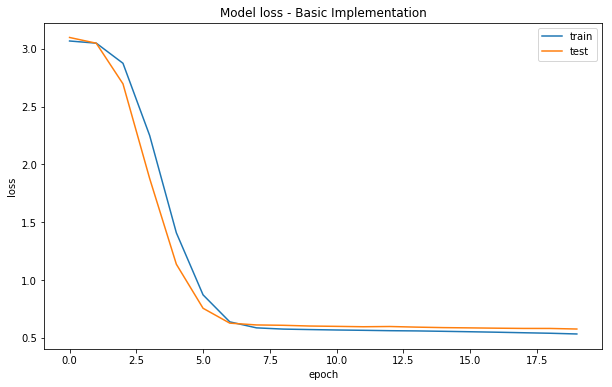

In [34]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - Basic Implementation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Computing Predictions with Predict Method

In [ ]:
nb_samples = 1000
mae, mse, mae_round,mse_round= 0,0,0,0

In [35]:
print('Next_User: %d | Next Item: %d' %(next_user,next_item))

Next_User: 90 | Next Item: 179


In [37]:
for i in range(nb_samples):
    sleep(0.05) # sleep to let the API breathe and allow others to call requests
    prediction =  model.predict([np.array(next_user).reshape(1,1), np.array(next_item).reshape(1,1)])[0][0]
    
    params['predicted_score'] = prediction 
    r=requests.get(url=url_predict,params=params)
    d=r.json()
    rating= d['rating'] # previous rating
    print('user: %s | item: %s | rating: %s | prediced rating: %s ' % (d['next_user'],d['next_item'],d['rating'],params['predicted_score']))
    next_user = d['next_user']
    next_item = d['next_item']
    
    mse+=(rating-prediction)**2
    mae+= abs(rating-prediction)
    mse_round+= (rating-round(prediction))**2
    mae_round+= abs(rating-round(prediction))

print('**')
print('Average MSE: ', mse/nb_samples)
print('Average MAE: ', mae/nb_samples)
print('**')
print('Average MSE with round: ', mse_round/nb_samples)
print('Average MAE with round : ', mae_round/nb_samples)

user: 51 | item: 257 | rating: 2 | prediced rating: 1.5404041 
user: 79 | item: 6 | rating: 1 | prediced rating: 2.081789 
user: 55 | item: 212 | rating: 5 | prediced rating: 5.337367 
user: 62 | item: 202 | rating: 5 | prediced rating: 4.57499 
user: 82 | item: 64 | rating: 2 | prediced rating: 1.8935226 
user: 25 | item: 242 | rating: 1 | prediced rating: 2.056718 
user: 33 | item: 96 | rating: 5 | prediced rating: 5.0262494 
user: 38 | item: 145 | rating: 2 | prediced rating: 2.203394 
user: 93 | item: 86 | rating: 1 | prediced rating: 1.3957572 
user: 12 | item: 214 | rating: 5 | prediced rating: 3.8505654 
user: 16 | item: 145 | rating: 2 | prediced rating: 2.6603343 
user: 52 | item: 128 | rating: 2 | prediced rating: 1.7077205 
user: 70 | item: 77 | rating: 3 | prediced rating: 2.3527942 
user: 65 | item: 102 | rating: 1 | prediced rating: 2.3081412 
user: 87 | item: 48 | rating: 2 | prediced rating: 1.9276023 
user: 1 | item: 219 | rating: 5 | prediced rating: 4.1400666 
user: 